In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copy
import os
import cv2 as cv

%matplotlib inline

In [2]:
# ROOT_DIR = os.curdir

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
ROOT_DIR = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/'
WORKING_DIR = '/kaggle/working/'

train_dir = os.path.join(WORKING_DIR, 'train')
valid_dir = os.path.join(WORKING_DIR, 'valid')

train_with_mask = os.path.join(train_dir, 'with_mask')
train_without_mask = os.path.join(train_dir, 'without_mask')
valid_with_mask = os.path.join(valid_dir, 'with_mask')
valid_without_mask = os.path.join(valid_dir, 'without_mask')

for dir_ in [train_dir, valid_dir, train_with_mask, train_without_mask, valid_with_mask, valid_without_mask]:
    os.makedirs(dir_, exist_ok=True)

In [4]:
# copying file from the root directory

for file in os.listdir(os.path.join(ROOT_DIR, 'Train/WithMask')):
    copy(os.path.join(ROOT_DIR, 'Train/WithMask', file), os.path.join(train_with_mask, file))
    
for file in os.listdir(os.path.join(ROOT_DIR, 'Train/WithoutMask')):
    copy(os.path.join(ROOT_DIR, 'Train/WithoutMask', file), os.path.join(train_without_mask, file))

for file in os.listdir(os.path.join(ROOT_DIR, 'Validation/WithMask')):
    copy(os.path.join(ROOT_DIR, 'Validation/WithMask', file), os.path.join(valid_with_mask, file))

for file in os.listdir(os.path.join(ROOT_DIR, 'Validation/WithoutMask')):
    copy(os.path.join(ROOT_DIR, 'Validation/WithoutMask', file), os.path.join(valid_without_mask, file))

In [6]:
train_mask_dir = os.path.join(WORKING_DIR, 'train')
valid_mask_dir = os.path.join(WORKING_DIR, 'valid')

In [8]:
# Getting counts

for path, name in [(train_mask_dir, 'train'), (valid_mask_dir, 'valid')]:
    print(f"{name.capitalize()} WITH MASK: {len(os.listdir(os.path.join(path, 'with_mask')))}")
    print(f"{name.capitalize()} WITHOUT MASK: {len(os.listdir(os.path.join(path, 'without_mask')))}")

Train WITH MASK: 5000
Train WITHOUT MASK: 5000
Valid WITH MASK: 400
Valid WITHOUT MASK: 400


## Visualize

In [12]:
train_with_mask_files = os.listdir(os.path.join(train_mask_dir, 'with_mask'))

In [16]:
train_with_mask_files[0]

'Augmented_403_973578.png'

Text(0.5, 1.0, 'Sixth Image')

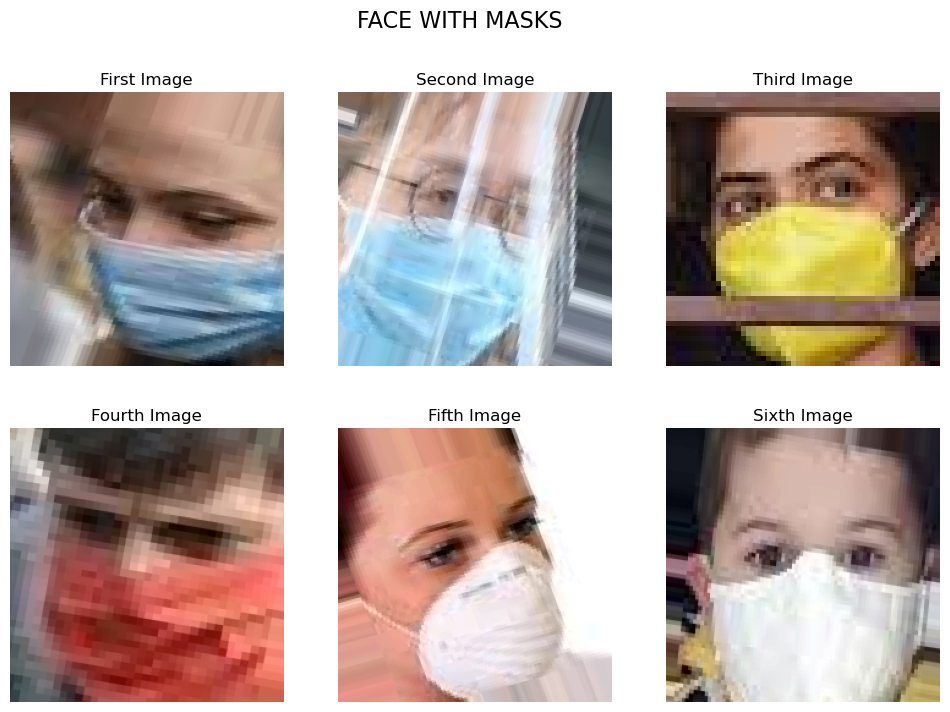

In [30]:
img1 = plt.imread(os.path.join(train_mask_dir, 'with_mask', train_with_mask_files[0]))
img2 = plt.imread(os.path.join(train_mask_dir, 'with_mask', train_with_mask_files[1]))
img3 = plt.imread(os.path.join(train_mask_dir, 'with_mask', train_with_mask_files[2]))
img4 = plt.imread(os.path.join(train_mask_dir, 'with_mask', train_with_mask_files[3]))
img5 = plt.imread(os.path.join(train_mask_dir, 'with_mask', train_with_mask_files[4]))
img6 = plt.imread(os.path.join(train_mask_dir, 'with_mask', train_with_mask_files[5]))

# creating subplots for the images
figure = plt.figure(figsize=(12,8))
figure.suptitle("FACE WITH MASKS", fontsize=16)

fig_rows = 2
fig_cols = 3

# Add a subplot at position 1
figure.add_subplot(fig_rows, fig_cols, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('First Image')

# Add a subplot at position 2
figure.add_subplot(fig_rows, fig_cols, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Second Image')

# Add a subplot at position 3
figure.add_subplot(fig_rows, fig_cols, 3)
plt.imshow(img3)
plt.axis('off')
plt.title('Third Image')

# Add a subplot at position 4
figure.add_subplot(fig_rows, fig_cols, 4)
plt.imshow(img4)
plt.axis('off')
plt.title('Fourth Image')

# Add a subplot at position 5
figure.add_subplot(fig_rows, fig_cols, 5)
plt.imshow(img5)
plt.axis('off')
plt.title('Fifth Image')


# Add a subplot at position 6
figure.add_subplot(fig_rows, fig_cols, 6)
plt.imshow(img6)
plt.axis('off')
plt.title('Sixth Image')

In [ ]:

def train_val_generator(training_dir, validation_dir):
    """
        Creates the training and validation generators
        
        Args:
        training_dir (string): directory path containing the training images
        validation_dir (string): directory path containing the validation images
        
        returns train_generator, validation_generator
    """
    
    train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=60,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    vertical_flip=True
                      )
    
    train_generator = train_datagen.flow_from_directory(training_dir, 
                                                        batch_size=12, 
                                                        class_mode='binary', 
                                                        target_size=(150,150))
    
    valid_datagen = ImageDataGenerator(rescale=1./255,)
    
    validation_generator = valid_datagen.flow_from_directory(validation_dir, 
                                                             batch_size=12, 
                                                             class_mode='binary', 
                                                             target_size=(150, 150))
    
    return train_generator, validation_generator

In [ ]:
train_generator, valid_generator = train_val_generator(train_mask_dir, valid_mask_dir)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications import InceptionResNetV2

def pretrained_model():
#     pretrained_model = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
    pretrained_model = InceptionResNetV2(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
    
    for layer in pretrained_model.layers:
        layer.trainable = False
        
    return pretrained_model

In [ ]:
pretrained_model = pretrained_model()

In [ ]:
def output(pretrained_model):
    last_desired_layer = pretrained_model#.get_layer('block_13_project')
    last_output = last_desired_layer.output
    return last_output

In [ ]:
last_output = output(pretrained_model)

In [ ]:
def create_final_model(pretrained_model, last_output):
    """
        Appends a custom model to a pretrained model
    """
    
    x = layers.Conv2D(64, (3,3), activation='relu', )(last_output)
#     x = layers.MaxPooling2D(3,3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=pretrained_model.input, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = create_final_model(pretrained_model, last_output)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, Callback as Cb

checkpoint = ModelCheckpoint('InceptionModel', save_best_only=True, verbose = 1)

class Callback(Cb):
    
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.992 and logs['val_accuracy'] > 0.992:
            self.model.stop_training = True
            
callback = Callback()

In [ ]:
EPOCHS = 100

history = model.fit(
    train_generator, 
    validation_data=valid_generator, 
    epochs=EPOCHS, 
    verbose=1, 
    callbacks=[callback, checkpoint])

In [ ]:
model.save('mask_model')

In [ ]:
!zip -r model.zip /kaggle/working/mask_model

In [ ]:
!ls

In [ ]:
from IPython.display import FileLink
FileLink(r'model.zip')

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
ax[0].plot(history.history['accuracy'],)
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[1].plot(history.history['loss'], color='g')
ax[1].plot(history.history['val_loss'], color='r')
ax[1].legend(['loss', 'val_loss'])
plt.savefig('plot.png')